In [174]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain

In [175]:
%%time
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0)]

divergence_event1 = msprime.MassMigration(time = 50, source = 1, dest = 0, proportion = 1)
divergence_event2 = msprime.MassMigration(time = 200, source = 2, dest = 0, proportion = 1)
# Simulate!
recomb = 0.5
mutation_rate = 0.1
ts_ref = msprime.simulate(population_configurations = pop_configs, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],
                      random_seed = 1, recombination_rate = recomb)
ref_stat = ts_ref.f3([pops[2],pops[0],pops[1]])
print(ref_stat)

24.003232323232325
Wall time: 12 ms


In [176]:
#ABC Function
def ABC(data,eps,pop_configs,pops,recomb,mutations,divergence2,prior ="exponential",prior_parameters=10,iters=1000):
    ref_stat = data.f3([pops[2],pops[0],pops[1]])
    samples = []
    norm_mean = 0
    if prior == "exponential":
        for iter in range(0,iterations):
            divergence_time = min(np.random.exponential(prior_parameters),200)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = ts_sim.f3([pops[2],pops[0],pops[1]])
            if abs(ref_stat-sim_stat) < eps:
                samples.append(divergence_time)
                norm_mean += np.linalg.norm(np.subtract(ref_stat,sim_stat))
            elif eps <= np.linalg.norm(np.subtract(ref_stat,sim_stat)) < 99999999:
                norm_mean += np.linalg.norm(np.subtract(ref_stat,sim_stat))
    if prior == "uniform":
        for iter in range(0,iterations):
            divergence_time = np.random.uniform(prior_parameters[0],prior_parameters[1])
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = ts_sim.f3([pops[2],pops[0],pops[1]])
            if abs(ref_stat-sim_stat) < eps:
                samples.append(divergence_time)
                norm_mean += np.linalg.norm(np.subtract(ref_stat,sim_stat))
            elif eps <= np.linalg.norm(np.subtract(ref_stat,sim_stat)) < 99999999:
                norm_mean += np.linalg.norm(np.subtract(ref_stat,sim_stat))
    return(samples,norm_mean/iterations)

In [177]:
%time
#Exponential prior rate 40 
iterations = 10000
eps = 0.1
prior= "exponential"
prior_parameters = 40
pops = [range(0,100),range(100,200),range(200,300)]
attempt1 = ABC(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)


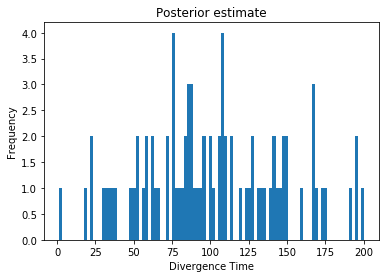

Acceptance probability : 0.0083
Mean norm :  12.334155749899356


In [178]:
plt.hist(attempt1[0], bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt1[0])/iterations)
print("Mean norm : ",attempt1[1])

In [179]:
%time
#Uniform(0,180) prior
iterations = 10000
eps = 0.1
prior= "uniform"
prior_parameters = (1,180)
pops = [range(0,100),range(100,200),range(200,300)]
attempt2 = ABC(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)


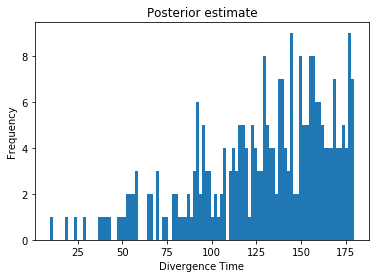

Acceptance probability : 0.0271
Mean norm :  8.238262867979977


In [180]:
plt.hist(attempt2[0], bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt2[0])/iterations)
print("Mean norm : ",attempt2[1])